# R: Bauldry ML Reserving Pt 3

*This article was originally created by Nigel Carpenter and published in the [General Insurance Machine Learning for Reserving Working Party (“MLR-WP”) blog](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/). The MLR-WP is an international research group on machine learning techniques to reserving, with over 50 actuaries from around the globe. The goal of the group is to bring machine learning techniques into widespread adoption ‘on the ground’ by identifying what the barriers are, communicating any benefits, and helping develop the research techniques in pragmatic ways. Whilst some articles have been brought into this cookbook, consider exploring the [blog](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/) further for additional content including detailed walkthroughs of more advanced models.*

# Introduction

This is the third notebook of a series of three that outlines and elaborates upon code used to replicate the central scenario in the paper of Maximilien Baudry "NON-PARAMETRIC INDIVIDUAL
CLAIM RESERVING IN INSURANCE"

[https://www.institutdesactuaires.com/global/gene/link.php?doc_id=11747&fg=1](https://www.institutdesactuaires.com/global/gene/link.php?doc_id=11747&fg=1)  
[http://chaire-dami.fr/files/2016/10/Reserving-article.pdf](http://chaire-dami.fr/files/2016/10/Reserving-article.pdf)

In this notebook we step through the process to apply machine learning techniques in order to create reserve estimates following the techniques set out in sections 3 and 4 of Baudry's paper. 

# Preparations before modelling

The reserving data structures built in this notebook are from a simulated phone insurance dataset. The creation of that simulated data and machine learning data structures for reserving have been set out in the first and second notebooks of this series.

Rather than repeat that code in this notebook the key routines and functions have been put into the r script *Baudry_functions_v2.R* enabling us to quickly load them for use in this notebook.


In [1]:
# Importing packages
library(knitr)
library(rmdformats)
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(formattable)
library(IRdisplay) # displays tables when in ipynb format

library(xgboost)
library(tidymodels)
library(SHAPforxgboost)

source("./Baudry_functions_v2.R")


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.9      ✔ rsample      0.1.1 
✔ dials        0.0.10     ✔ tibble       3.1.6 
✔ dplyr        1.0.7      ✔ tidyr        1.1.4 
✔ infer        1.0.0      ✔ tune         0.1.6 
✔ modeldata    0.1.1      ✔ workflows    0.2.4 
✔ parsnip      0.1.7      ✔ workflowsets 0.1.0 
✔ purrr        0.3.4      ✔ yardstick    0.0.9 
✔ recipes      0.1.17     

── Conflicts ───────────────────────────────────────── tidymode

# Simulate data and prepare database

We can now quickly repeat the process from Notebooks 1 and 2 using the functions in the script.

## Simulate policy and claim data

We start with a simulated phone insurance policy and claim dataset. I am calling the function from Notebook 1 of this series to create the dataset. Using a fixed seed will ensure you get a reproducible simulated dataset.

In [2]:

dt_PhoneData <- simulate_central_scenario(1234)


## Join policy and claim data

We then join the simulated phone insurance policy and claim dataset. I have taken the code from Notebook 2 and wrapped it in to a function to perform the join  and subsequent data tidying. 

Note that if you are working with your own company data you would likely need to amend this function to work with the specifics of your data.  



In [3]:

dt_polclaim <- join_policy_claim(dt_PhoneData,
                                 date_pol_start = "date_UW",
                                 date_pol_end = "date_lapse",
                                 date_occur = "date_occur")


## Timeslice policy claim 

We then time slice the joined policy and claim dataset. Again, I have taken the code from Notebook 2 and wrapped it into a function to perform the time slicing, given a set of dates that define the time slice periods.

Again, note that this function would need to be re-written to work with your own company data and more importantly it currently would not work correctly with partial payment claims. 

In [4]:
lst_Date_slice <- floor_date(seq(as.Date("2016/1/1"), as.Date("2019/06/30"), by = 30), unit= "second") 
dt_polclaim <- time_slice_polclaim(dt_polclaim, lst_Date_slice)

## Select valuation date

Before we create the RBNS and IBNER datasets we must pick a valuation point from the available timeslices. I'm selecting the 10th point for illustration, which is the 10th 30 day period from 01/01/2016, ie a valuation date of 27/09/2016.

In [5]:

i <- valuation <- 10
t_i <- lst_Date_slice[i] 
delta <- min(i, length(lst_Date_slice) - i + 1)



## Creating RBNS dataset

We start with the RBNS dataset and by defining the list of features that will be used in the RBNS model dataset.

As you follow this example you may observe that we are not using the historic claim payment information as an explanatory feature in the RBNS reserve prediction model. Baudry's paper and approach does allow for the inclusion of such information so it may seem somewhat strange not to include it in this worked example.  

I believe the reason that it is not included is a result of the way data has been simulated, specifically that simulated claims are settled with a single payment. That assumption combined with the fact that this method is being applied to individual claim level data prevents the previous time period's payment information being used by a machine learning model. That is because the previous period's payment amount can only ever take the value zero for a claim requiring an RBNS reserve. (Claims where the previous paid is non-zero have been paid and settled ie no longer require an RBNS reserve). Consequently, in this central simulated example, prior payment amount is uninformative in the machine learning process and therefore cannot be included as a feature in the RBNS dataset.

The final point to note is that the code shared here deals only with the simplified payment process from Baudry’s central scenario, ie claims are settled with a single payment. Real world data with partial payments and prior payments as explanatory features would require material changes to be made to the code we have shared. Such changes are left for interested readers to make.


In [6]:

#define modelVars
RBNS_model_vars <- c("clm_number",
                     "pol_number",
                     "j",
                     "k",
                     "date_pol_start",
                     "date_occur",
                     "date_report",
                     "date_pay",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     "target"
    )


# Create a combined TRAIN dataset for k = 1 and all valid j delay values
dt_RBNS_train <- RBNS_Train(dt_polclaim, t_i, i, k = 1, lst_Date_slice, RBNS_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_RBNS_test <- RBNS_Test(dt_polclaim, t_i, delta, k = 1, lst_Date_slice, RBNS_model_vars)


The train and test datasets are then joined into a single dataset and a small amount of tidying is done to make them ready for use.

In [7]:

# Add a flag to determine which rows are from the trainset and which from the test set
dt_RBNS_train[, flgTrain := 1]
dt_RBNS_test[, flgTrain := 0]

# combine into a single RBNS dataset   
dt_All_RBNS <- rbind(dt_RBNS_train, dt_RBNS_test)
#write.csv(dt_All_RBNS,"dt_All_RBNS.csv", row.names = F)


In [8]:
# tidy up
rm(dt_RBNS_train)
rm(dt_RBNS_test)
gc()
    

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2937783,156.9,5633064,300.9,NA,3749631,200.3
Vcells,40910877,312.2,71898293,548.6,16384,49751179,379.6


The important aspects of the tidying relate to creating useable delay metrics from the numerous dates and converting some character features such as cover and claim type into factors.

In [9]:
# order and create some delay fields
setkey(dt_All_RBNS, clm_number, k, j)
    
dt_All_RBNS[, Count := .N , by =clm_number]

#create delay measures and convert time measures from intervals of seconds to intervals of days
dt_All_RBNS[, ':='(
  delay_uw_occ = ifelse(year(date_occur) == 2199,
                        -1,
                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start)) / (24 * 60 * 60))
                        ),
  delay_occ_rep = ifelse(year(date_occur) == 2199,
                         -1,
                         ceiling((as.numeric(date_report) - as.numeric(date_occur)) / (24 * 60 * 60))
                         ),
  delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start)) / (24 * 60 * 60)),
  delay_rep_pay = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60)),
  
  date_uw = ceiling(as.numeric(date_pol_start) / (24 *  60 * 60)),
  Cover = as.factor(Cover),
  claim_type = as.factor(claim_type)
  )]
  


## Creating IBNR dataset

We can then create the IBNR dataset following a similar procedure starting by defining the list of features that will be used in the IBNR model. Then we call the functions that convert the timesliced policy and claim data into the IBNR train and test datasets.

In [10]:
#define IBNR modelVars
IBNR_model_vars <- c("clm_number",
                     "pol_number",
                     "j",
                     "k",
                     "exposure",
                     "date_pol_start",
                     "date_occur",
                     "date_report",
                     "date_pay",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "target")
    
# Create a combined TRAIN dataset for k = 1 and all valid j delay values
lst_IBNR_train <- IBNR_Train(dt_polclaim, t_i, i, k = 1,lst_Date_slice, IBNR_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_IBNR_test <- IBNR_Test(dt_polclaim, t_i, delta, k = 1,lst_Date_slice, IBNR_model_vars)


The train and test datasets are then joined into a single dataset and a small amount of tidying is done to make them ready for use.

In [11]:

lst_IBNR_train$Freq[, flgTrain := 1]
lst_IBNR_train$Loss[, flgTrain := 2]
dt_IBNR_test[, flgTrain := 0]

dt_All_IBNR <- rbind(lst_IBNR_train$Freq,
                     lst_IBNR_train$Loss,
                     dt_IBNR_test)
#write.csv(dt_All_IBNR,"dt_All_IBNR.csv", row.names = F)

In [12]:

# tidy up
rm(lst_IBNR_train)
rm(dt_IBNR_test)
gc()



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2945462,157.4,5633064,300.9,NA,4008351,214.1
Vcells,75769710,578.1,149517738,1140.8,16384,123984472,946.0


The important aspects of the tidying relate to creating useable delay metrics from the numerous dates and converting some character features such as cover and claim type into factors.

In [13]:
# order and create some delay fields
setkey(dt_All_IBNR, clm_number, k, j)
    
dt_All_IBNR[, Count := .N , by =clm_number]
dt_All_IBNR[,':='( delay_uw_occ = ifelse(year(date_occur) == 2199,
                                        -1,
                                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start))
                                                  /(24*60*60))
                                          ),
                   delay_occ_rep = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_report) - as.numeric(date_occur))
                                                  /(24*60*60))
                                          ),
                   delay_rep_pay = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_pay) - as.numeric(date_report))
                                                  /(24*60*60))
                                          ),
                   delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start))/(24*60*60)),
                   date_uw = ceiling(as.numeric(date_pol_start)/(24*60*60)),
                   Cover = as.factor(Cover))]

That finishes the data preparation. We can now move onto the process of building models of RBNS and IBNR and using them to predict the current reserve requirements.

# Model build

I will use the xgboost R machine learning  package to build the models. In Baudry's original paper he used the extraTrees package; a variant upon Random Forests. 

Xgboost has been selected as it is the most popular implementation of the gradient boosting machine (GBM) algorithm. GBMs have been known since around 2015 to be the most accurate algorithmic technique for regression and classification tasks.  

The code and modeling process for each reserve type is very similar so they are shown in the tabbed sections below rather that repeating in-line.

## RBNS model

Starting with the RBNS reserves we will first build a model upon the training data using a cross validated approach to enable selection of key xgboost hyperparameters. 

Then using optimal parameters we retrain on the complete training dataset. This trained model is then scored against the test data in order to create predictions from which the RBNS reserve can be calculated.

### Creating xgboost dataset

Xgboost requires it's data to be in a specific format; a special matrix form called a DMatrix, for which there is a function `xgb.DMatrix`. Not all variable types can be passed to `xgb.DMatrix` in particular categorical or nominal variables such as **Brand** have to be converted from text to numeric values.  

For this example I've chosen to use the `parsnip` package and create a recipe that converts nominal predictor values into a **one-hot-encoded** form. 

In [14]:
RBNS_predictors <- c("j",
                     "k",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     #"date_uw",
                     #"delay_uw_occ",
                     "delay_occ_rep")

rowList_RBNS <- list(train=dt_All_RBNS[, which(flgTrain==1)],
                test=dt_All_RBNS[, which(flgTrain==0)],
                all = 1:nrow(dt_All_RBNS))


RBNS_rec <- recipe( ~ ., data = dt_All_RBNS[, RBNS_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()


df.RBNS_train <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$train,] )
df.RBNS_test <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$test,] )
df.RBNS_all <- bake(RBNS_rec, new_data = dt_All_RBNS )


xgb.RBNS_DMat.train <- xgb.DMatrix(data = as.matrix(df.RBNS_train),
                              label = dt_All_RBNS[rowList_RBNS$train, target])

xgb.RBNS_DMat.test <- xgb.DMatrix(data = as.matrix(df.RBNS_test),
                              label = dt_All_RBNS[rowList_RBNS$test, target])

xgb.RBNS_DMat.all <- xgb.DMatrix(data = as.matrix(df.RBNS_all),
                             label = dt_All_RBNS[, target])


### Fit initial model using cross validation

Having prepared the data for xgboost I can now fit an initial model. I've used a simple set of hyper-parameters and used cross validation to select the optimal number of boosted trees (nrounds) for these hyper-parameter selections by calling the xgb.cv function with early stopping.

I have used the **reg:tweedie** objective function based upon inspection of the target variable.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   76.44    0.00  913.00 

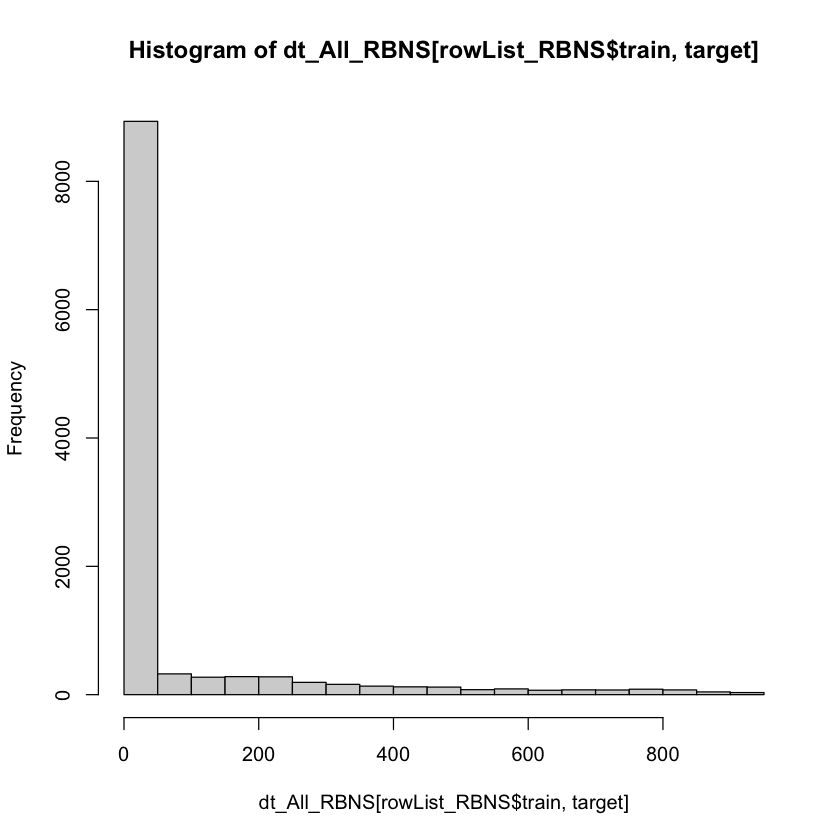

In [15]:


summary(dt_All_RBNS[rowList_RBNS$train, target])
hist(dt_All_RBNS[rowList_RBNS$train, target])



In a real world example a process of hyper-parameter tuning would be undertaken in order to select more optimal xgboost hyper-parameters.

In [16]:

param <- list(
  objective = "reg:tweedie",
  max_depth = 2L,            # tree-depth
  subsample = 0.75,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,    # randomly sample columns before fitting each tree
  min.child.weight = 10,     # minimum weight per leaf
  eta = 0.1                  # Learning rate
)


# Train model with cross validation
set.seed(1984) # for repeatability

xgb_RBNS_CV <- xgb.cv(
  params                 = param,
  data                   = xgb.RBNS_DMat.train,
  nrounds                = 500,        # Maximum number of trees to build
  nfold = 5,
  early_stopping_rounds  = 10L,        # Stops algorithm early if performance has not improved in 
  print_every_n          = 10L,        # How often to print to console
  prediction             = TRUE        # Keeps the predictions
)


[1]	train-tweedie-nloglik@1.5:197.200147+1.066135	test-tweedie-nloglik@1.5:197.212884+4.843435 
Multiple eval metrics are present. Will use test_tweedie_nloglik@1.5 for early stopping.
Will train until test_tweedie_nloglik@1.5 hasn't improved in 10 rounds.

[11]	train-tweedie-nloglik@1.5:76.197815+0.211998	test-tweedie-nloglik@1.5:76.203892+2.163219 
[21]	train-tweedie-nloglik@1.5:34.536194+0.258204	test-tweedie-nloglik@1.5:34.527821+1.059959 
[31]	train-tweedie-nloglik@1.5:22.707742+0.180634	test-tweedie-nloglik@1.5:22.711464+0.644633 
[41]	train-tweedie-nloglik@1.5:20.142523+0.042449	test-tweedie-nloglik@1.5:20.169496+0.415564 
[51]	train-tweedie-nloglik@1.5:19.651481+0.052902	test-tweedie-nloglik@1.5:19.680118+0.344643 
[61]	train-tweedie-nloglik@1.5:19.508132+0.061030	test-tweedie-nloglik@1.5:19.550804+0.321765 
[71]	train-tweedie-nloglik@1.5:19.449044+0.065773	test-tweedie-nloglik@1.5:19.501728+0.312207 
[81]	train-tweedie-nloglik@1.5:19.419057+0.070073	test-tweedie-nloglik@1.5:19

Having fit the model we store the out-of-fold predictions.

In [17]:

dt_All_RBNS[rowList_RBNS$train, preds_oof := xgb_RBNS_CV$pred]


### Fit final model on all training data

Having fit the model using 5 fold cross validation we observe the optimum number of fitting rounds to be `r xgb_RBNS_CV$best_iteration`.  

We can then use this to train a final model on all the data. 

In [18]:


xgb_RBNS_Fit <- xgb.train(
  params                 = param,
  data                   = xgb.RBNS_DMat.train,
  nrounds                = xgb_RBNS_CV$best_iteration,
# base_score             = 1,
  watchlist              = list(train=xgb.RBNS_DMat.train, test=xgb.RBNS_DMat.test) ,
  print_every_n          = 10
)

dt_All_RBNS[, preds_full := predict(xgb_RBNS_Fit,xgb.RBNS_DMat.all)]



[1]	train-tweedie-nloglik@1.5:197.147781	test-tweedie-nloglik@1.5:82.766273 
[11]	train-tweedie-nloglik@1.5:75.850830	test-tweedie-nloglik@1.5:32.106102 
[21]	train-tweedie-nloglik@1.5:34.154110	test-tweedie-nloglik@1.5:14.514384 
[31]	train-tweedie-nloglik@1.5:22.479488	test-tweedie-nloglik@1.5:9.615996 
[41]	train-tweedie-nloglik@1.5:20.106234	test-tweedie-nloglik@1.5:8.624282 
[51]	train-tweedie-nloglik@1.5:19.618027	test-tweedie-nloglik@1.5:8.393838 
[61]	train-tweedie-nloglik@1.5:19.490944	test-tweedie-nloglik@1.5:8.321967 
[71]	train-tweedie-nloglik@1.5:19.442141	test-tweedie-nloglik@1.5:8.283491 
[81]	train-tweedie-nloglik@1.5:19.419815	test-tweedie-nloglik@1.5:8.265779 
[91]	train-tweedie-nloglik@1.5:19.399960	test-tweedie-nloglik@1.5:8.258656 
[101]	train-tweedie-nloglik@1.5:19.387503	test-tweedie-nloglik@1.5:8.257319 
[111]	train-tweedie-nloglik@1.5:19.373995	test-tweedie-nloglik@1.5:8.257586 
[112]	train-tweedie-nloglik@1.5:19.373476	test-tweedie-nloglik@1.5:8.257521 


### Inspect model fit

Having fitted the full model we can then inspect the model fit. The traditional way of inspecting global model feature importance is to use the gains chart. 

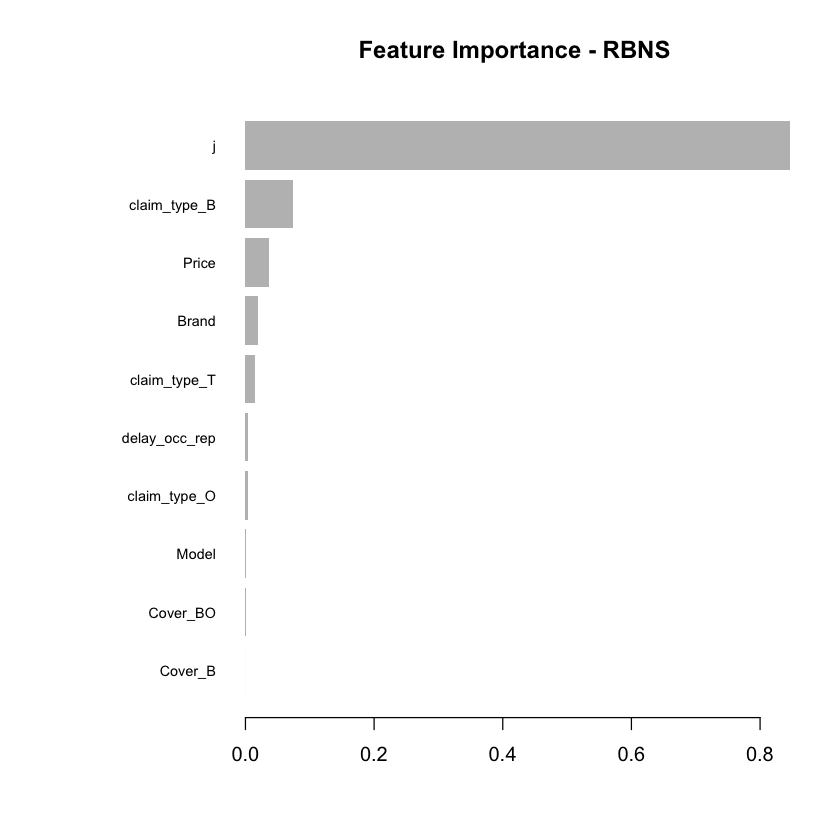

In [19]:

#default feature importance by gain
featImp_RBNS <- xgb.importance(xgb_RBNS_Fit, feature_names = colnames(xgb.RBNS_DMat.train))
xgb.plot.importance(featImp_RBNS, main="Feature Importance - RBNS")


An increasingly popular and more robust approach is to use SHAP values [https://github.com/slundberg/shap](http://).  The SHAP equivalent of the feature importance chart is shown below.

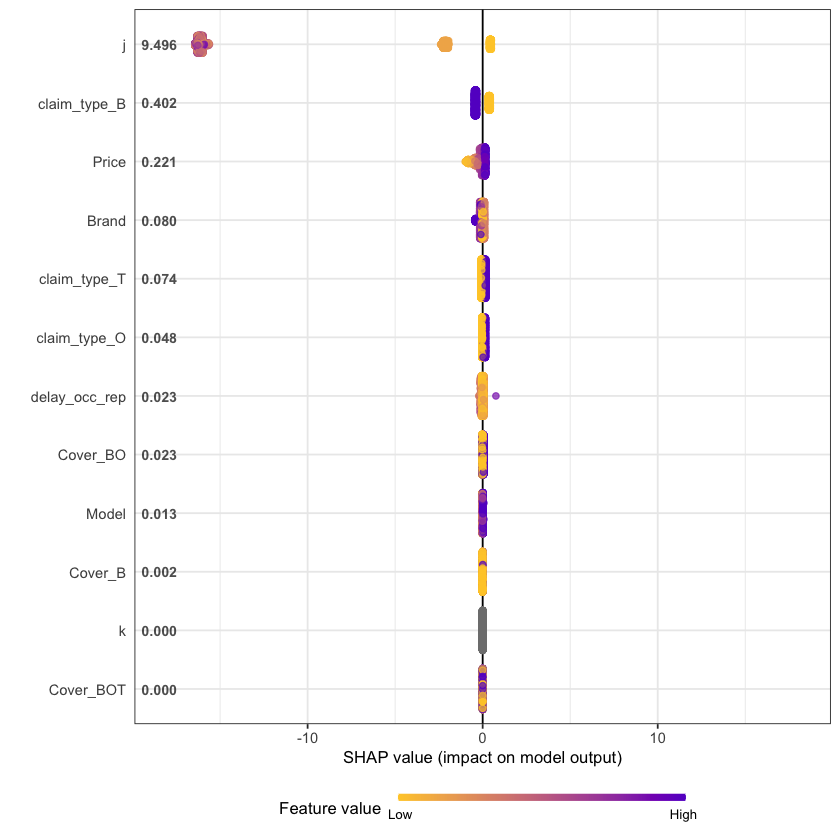

In [20]:
# Return the SHAP values and ranked features by mean|SHAP|
shap_values <- shap.values(xgb_model = xgb_RBNS_Fit, X_train = as.matrix(df.RBNS_train))

# Prepare the long-format data:
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train =  as.matrix(df.RBNS_train))

# **SHAP summary plot**
shap.plot.summary(shap_long, dilute = nrow(df.RBNS_train)/10000)

A second useful chart is the partial dependence plot. This shows how the values of a predictive (input) feature influence the predicted (output) value, while holding the values of all other predictive (input) features constant. It is also known as the marginal effect.

Here we show the partial dependence plots for the top 4 SHAP features.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  3.0861e-30”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“rec

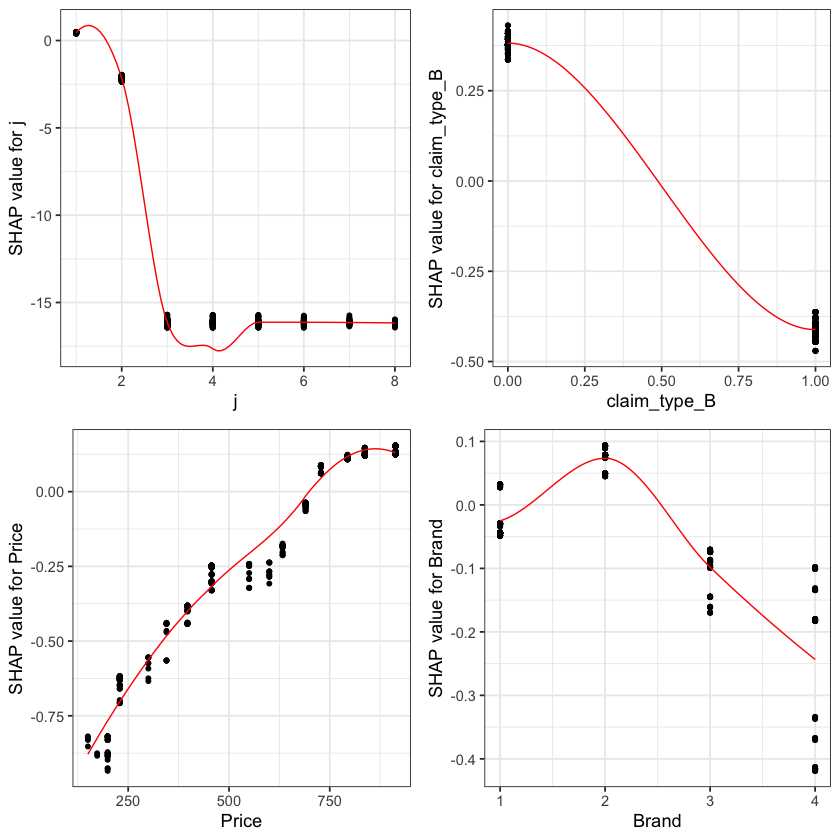

In [21]:
fig_list <- lapply(names(shap_values$mean_shap_score)[1:4], 
                   shap.plot.dependence,
                   data_long = shap_long,
                   dilute = nrow(shap_long)/ 10000)

gridExtra::grid.arrange(grobs = fig_list, ncol = 2)

The feature importance and partial dependency plots provide quick insight into the model.  

* We see that claim development period, j, is the most important feature and that the RBNS reserve is smaller for larger values of j.
* The second most important feature is claimtype where breakage claims are associated with lower RBNS reserves. This is as expected from the data generating process where breakage claims come from a Beta distribution with a lower mean.
* The third most important feature is phone price where there is linear increase in RBNS reserve with increasing phone price. This is also as expected from the data generating process.
* The fourth feature is phone brand which again follows expectations from the data generating process. 

SHAP values can also be used to show the components of a single prediction. In the following plot we show the top 4 components for each row of the data and zoom in at row 500. 

The SHAP values of the Rest 8 features were summed into variable 'rest_variables'.


Data has N = 833 | zoom in length is 83 at location 500.




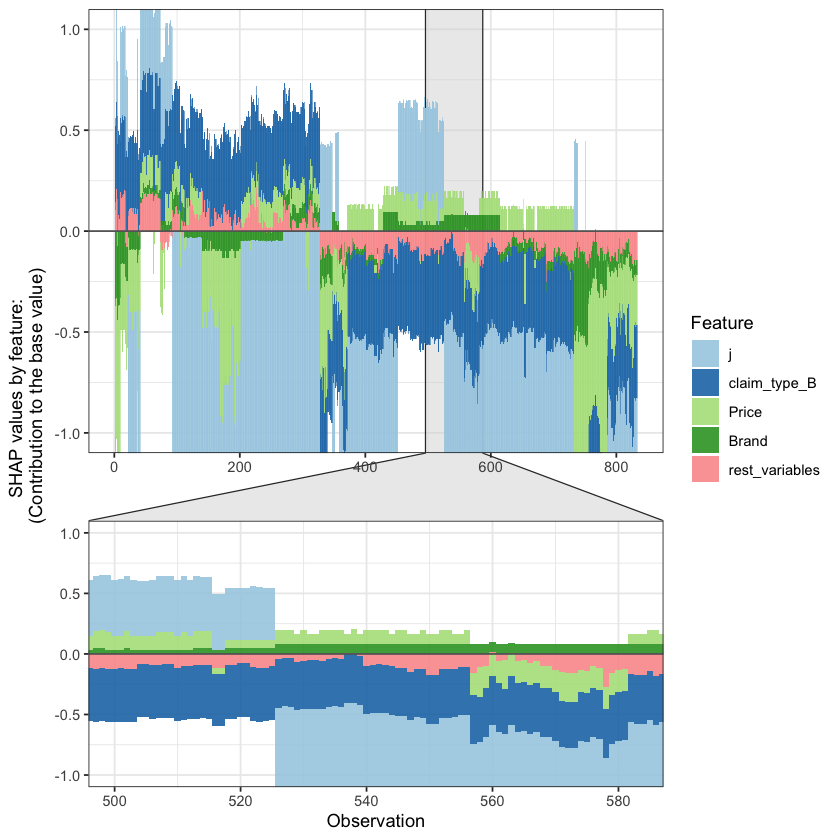

In [22]:
# choose to show top 4 features by setting `top_n = 4`, set 6 clustering groups.  
plot_data <- shap.prep.stack.data(shap_contrib = shap_values$shap_score,
                                  data_percent = 10000/nrow(shap_long),
                                  top_n = 4,
                                  n_groups = 6)
  
# choose to zoom in at location 500, set y-axis limit using `y_parent_limit`  
# it is also possible to set y-axis limit for zoom-in part alone using `y_zoomin_limit`  
shap.plot.force_plot(plot_data, zoom_in_location = 500, y_parent_limit = c(-1,1))
  

### Summarising RBNS reserves

By comparing the model predictions to the simulated claims run-off we can get a feel for the accuracy of the machine learning approach. Below I aggregate the RBNS predictions by claim occurrence month and compare them to the known simulated claim run-off.

In [23]:


dt_All_RBNS [, date_occur_YYYYMM := as.character(year(date_occur) + month(date_occur)/100 )]

dt_RBNS_summary <- dt_All_RBNS[rowList_RBNS$test,.(preds = sum(preds_full), target = sum(target)), keyby = date_occur_YYYYMM]



In [24]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_occur_YYYYMM = "Total"), dt_RBNS_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_RBNS_summary <- rbind(dt_RBNS_summary, sumrow, fill = TRUE)

dt_RBNS_summary[, ':='(Diff = (preds - target),
                       Diff_pcnt =  scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_RBNS_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()


date_occur_YYYYMM,preds,target,Diff,Diff_pcnt
2016.04,"1,341",911,430,47.2%
2016.05,"5,442","5,188",254,4.9%
2016.06,"12,704","14,257","-1,553",-10.9%
2016.07,"56,579","53,815","2,764",5.1%
2016.08,"325,344","326,631","-1,287",-0.4%
2016.09,"619,875","622,179","-2,304",-0.4%
Total,"1,021,285","1,022,981","-1,696",-0.2%


You can now jump back up to the beginning of the modeling section and select the IBNR frequency modeling tab. 

## IBNR Frequency model

IBNR reserves are built by multiplying the outpts of a claim frequency and claim severity model. The general process of building the model follows that of the RBNS reserves. 

### Creating xgboost dataset

Again we convert the data into a specific matrix form called a DMatrix. However before doing so we aggregate the data for efficiency of model fit times. There could be a loss of accuracy in aggregating data, so in practice this is something you would want to experiment with. 

The other point to note is the values of **flgTrain** used to identify the training and test rows in our dataset. Recall from Notebook 2, in the IBNR dataset training rows for the frequency model have a flgtrain value of 1 whereas the Severity training rows have a value of 2. 

In [25]:
IBNR_predictors <- c("j",
                     "k",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "date_uw")

# aggregate the data ... does this lead to loss of variance and accuracy?
dt_All_IBNR [, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100 )]

dt_All_IBNR_F <- dt_All_IBNR[, .(exposure = sum(exposure),
                                   target_cost = sum(target),
                                   target_count = sum(target>0)),
                               by= c(IBNR_predictors, "date_pol_start_YYYYMM", "flgTrain")]

dt_All_IBNR_F <- dt_All_IBNR_F[exposure>0]


# setup train and test rows
rowList_IBNR_F <- list(train=dt_All_IBNR_F[, which(flgTrain==1)],
                     test=dt_All_IBNR_F[, which(flgTrain==0)],
                     all = dt_All_IBNR_F[, which(flgTrain!=2)])

# setup data for xgboost
IBNR_rec <- recipe( ~ ., data = dt_All_IBNR_F[, IBNR_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

df.IBNR_F_train <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$train,] )
df.IBNR_F_test <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$test,] )
df.IBNR_F_all <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$all,] )

xgb.IBNR_F_DMat.train <- xgb.DMatrix(data = as.matrix(df.IBNR_F_train),
                              weight = dt_All_IBNR_F[rowList_IBNR_F$train, exposure],
                              label = dt_All_IBNR_F[rowList_IBNR_F$train, target_count])

xgb.IBNR_F_DMat.test <- xgb.DMatrix(data = as.matrix(df.IBNR_F_test),
                             weight = dt_All_IBNR_F[rowList_IBNR_F$test, exposure],
                             label = dt_All_IBNR_F[rowList_IBNR_F$test, target_count])

xgb.IBNR_F_DMat.all <- xgb.DMatrix(data = as.matrix(df.IBNR_F_all),
                            weight = dt_All_IBNR_F[rowList_IBNR_F$all, exposure],
                            label = dt_All_IBNR_F[rowList_IBNR_F$all, target_count])

### Fit initial model using cross validation

Having prepared the data for xgboost I can now fit an initial model. I’ve used a simple set of hyper-parameters and used cross validation to select the optimal number of boosted trees (nrounds) for these hyper-parameter selections by calling the xgb.cv function with early stopping. 

I have used the **count:poisson** objective function based upon inspection of the target variable.

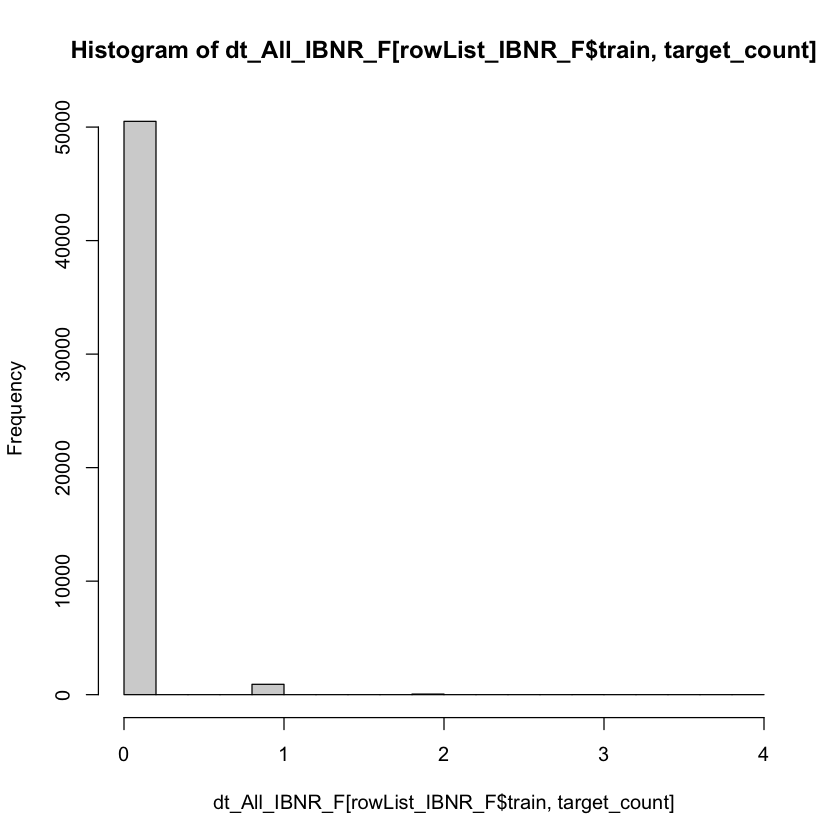

In [26]:
hist(dt_All_IBNR_F[rowList_IBNR_F$train, target_count])



In [27]:


param <- list(
  objective = "count:poisson",
  max_depth = 2L,           # tree-depth
  subsample = 0.7,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,   # randomly sample columns before fitting each tree
  min.child.weight = 10,    # minimum weight per leaf
  eta = 0.1               # Learning rate
  #monotone_constraints = monotone_Vec # Monotonicity constraints
)


# Train model with cross validation
set.seed(1984) # for repeatability

xgb_IBNR_F_CV <- xgb.cv(
 params                 = param,
 data                   = xgb.IBNR_F_DMat.train,
 nrounds                = 2000,        # Maximum number of trees to build
 nfold = 5,

 early_stopping_rounds  = 50L,        # Stops algorithm early if performance has not improved in n rounds
 print_every_n          = 50L,        # How often to print to console
 #base_score             = 0.001,       # Model starting point
   prediction             = TRUE        # Keeps the predictions
)


[1]	train-poisson-nloglik:0.509639+0.000413	test-poisson-nloglik:0.509646+0.001705 
Multiple eval metrics are present. Will use test_poisson_nloglik for early stopping.
Will train until test_poisson_nloglik hasn't improved in 50 rounds.

[51]	train-poisson-nloglik:0.161843+0.002167	test-poisson-nloglik:0.162117+0.005715 
[101]	train-poisson-nloglik:0.136649+0.002226	test-poisson-nloglik:0.137008+0.008028 
[151]	train-poisson-nloglik:0.132533+0.002259	test-poisson-nloglik:0.133765+0.008356 
[201]	train-poisson-nloglik:0.130754+0.002232	test-poisson-nloglik:0.133048+0.008725 
[251]	train-poisson-nloglik:0.129527+0.002201	test-poisson-nloglik:0.132851+0.008859 
[301]	train-poisson-nloglik:0.128530+0.002113	test-poisson-nloglik:0.132896+0.009030 
Stopping. Best iteration:
[266]	train-poisson-nloglik:0.129220+0.002207	test-poisson-nloglik:0.132820+0.008904



Having fit the model we store the out-of-fold predictions for both the claim frequency and the claim counts.

In [28]:

 dt_All_IBNR_F[rowList_IBNR_F$train, preds_oof_IBNR_F := xgb_IBNR_F_CV$pred]
 dt_All_IBNR_F[rowList_IBNR_F$train, preds_oof_IBNR_Nos := exposure * preds_oof_IBNR_F]


### Fit final model on all training data

Having fit the model using 5 fold cross validation we observe the optimum number of fitting rounds to be `r xgb_IBNR_F_CV$best_iteration`. 

We can then use this to train a final model on all the data. 

In [29]:


xgb_IBNR_F_Fit <- xgb.train(
   params                 = param,
   data                   = xgb.IBNR_F_DMat.train,
   nrounds                = xgb_IBNR_F_CV$best_iteration,
# base_score             = 1,
   watchlist              = list(train=xgb.IBNR_F_DMat.train, test=xgb.IBNR_F_DMat.test) ,
   print_every_n          = 50
 )
 
 dt_All_IBNR_F[rowList_IBNR_F$all, preds_full_IBNR_Nos := predict(xgb_IBNR_F_Fit,xgb.IBNR_F_DMat.all)]


[1]	train-poisson-nloglik:0.509602	test-poisson-nloglik:0.497374 
[51]	train-poisson-nloglik:0.161682	test-poisson-nloglik:0.119256 
[101]	train-poisson-nloglik:0.136589	test-poisson-nloglik:0.087910 
[151]	train-poisson-nloglik:0.132685	test-poisson-nloglik:0.083935 
[201]	train-poisson-nloglik:0.131112	test-poisson-nloglik:0.083199 
[251]	train-poisson-nloglik:0.129959	test-poisson-nloglik:0.083135 
[266]	train-poisson-nloglik:0.129688	test-poisson-nloglik:0.083093 


### Inspect model fit

Having fitted the full model we can then inspect the model fit. The traditional way of inspecting global model feature importance is to use the gains chart.

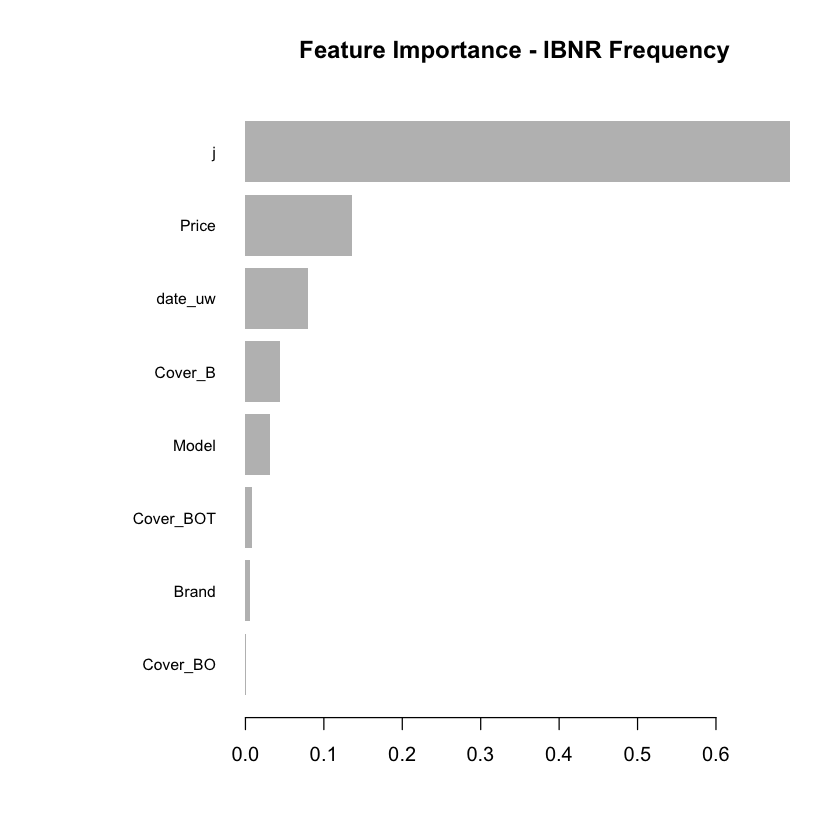

In [30]:

#default feature importance by gain
featImp_IBNR_F <- xgb.importance(xgb_IBNR_F_Fit, feature_names = colnames(xgb.IBNR_F_DMat.train))
xgb.plot.importance(featImp_IBNR_F, main="Feature Importance - IBNR Frequency")



An increasingly popular and more robust approach is to use SHAP  values [https://github.com/slundberg/shap](http://).  The SHAP equivalent of the feature importance chart is shown below.

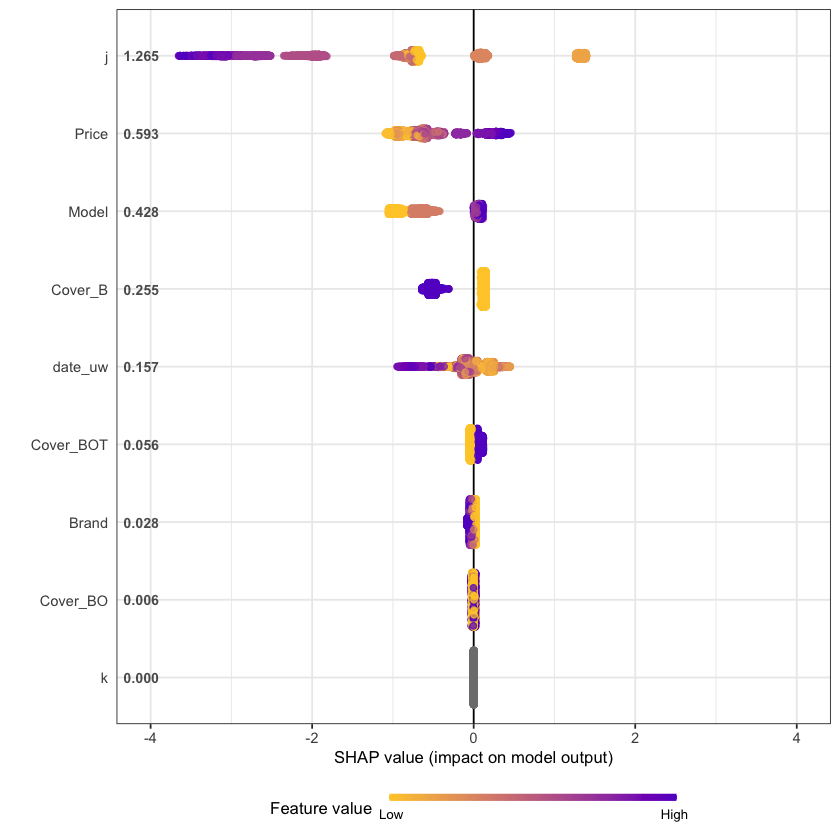

In [31]:


# Return the SHAP values and ranked features by mean|SHAP|
shap_values <- shap.values(xgb_model = xgb_IBNR_F_Fit, X_train = as.matrix(df.IBNR_F_train))

# Prepare the long-format data:
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train =  as.matrix(df.IBNR_F_train))

# **SHAP summary plot**
shap.plot.summary(shap_long, dilute = nrow(df.IBNR_F_train)/10000)


  

A second useful chart is the partial dependence plot. This shows how the values of a predictive (input) feature influence the predicted (output) value, while holding the values of all other predictive (input) features constant. It is also known as the marginal effect.

Here we show the partial dependence plots for the top 4 SHAP features.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.015”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.3627e-15”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0602”
`geom_smooth()` using formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“

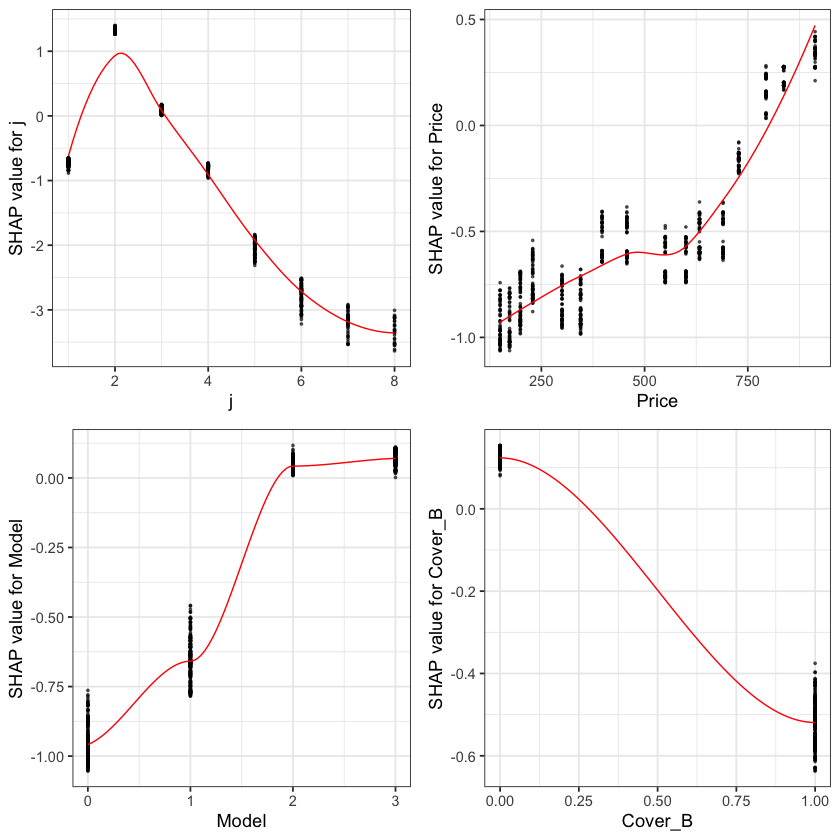

In [32]:


fig_list <- lapply(names(shap_values$mean_shap_score)[1:4], 
                   shap.plot.dependence,
                   data_long = shap_long,
                   dilute = nrow(shap_long)/ 10000)

gridExtra::grid.arrange(grobs = fig_list, ncol = 2)



The feature importance and partial dependency plots provide quick insight into the model.  

* We see that claim development period, j, is the most important feature and that the IBNR frequency is smaller for larger values of j.
* The second most important feature is phone price with the IBNR claim count increasing as price increases. Although this is not a direct feature in the data generating process there is a link with higher theft frequencies and higher phone prices. 
* The third most important feature is phone model with IBNR frequency increasing with model type. This is expected from the data generating process as theft claim frequency increases with model type.
* The fourth feature is phone cover and it should be no suprise to see that Breakage only, the most basic cover level is associated with lower IBNR claim counts. 

SHAP values can also be used to show the components of a single predction. In the following plot we show the top 4 components for each row of the data and zoom in at row 500. 

The SHAP values of the Rest 5 features were summed into variable 'rest_variables'.


Data has N = 1111 | zoom in length is 111 at location 500.




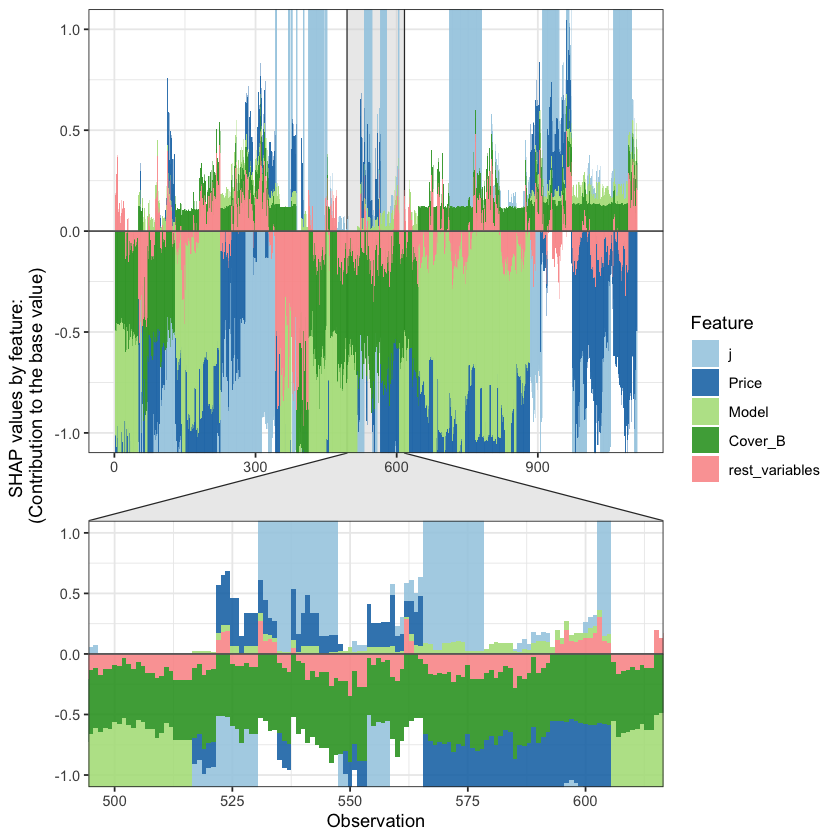

In [33]:

# choose to show top 4 features by setting `top_n = 4`, set 6 clustering groups.  
plot_data <- shap.prep.stack.data(shap_contrib = shap_values$shap_score,
                                  data_percent = 10000/nrow(shap_long),
                                  top_n = 4,
                                  n_groups = 6)
  
# choose to zoom in at location 500, set y-axis limit using `y_parent_limit`  
# it is also possible to set y-axis limit for zoom-in part alone using `y_zoomin_limit`  
shap.plot.force_plot(plot_data, zoom_in_location = 500, y_parent_limit = c(-1,1))
  


### Summarising IBNR claim counts

By comparing the model predictions to the simulated claims run-off we can get a feel for the accuracy of the machine learning approach. Below I aggregate the IBNR claim count predictions by claim occurrence month and compare them to the known simulated claim run-off.

In [34]:


dt_All_IBNR_F_summary <- dt_All_IBNR_F[rowList_IBNR_F$test,.(preds = sum(preds_full_IBNR_Nos), target = sum(target_count)), keyby = date_pol_start_YYYYMM]



In [35]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_pol_start_YYYYMM = "Total"), dt_All_IBNR_F_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_All_IBNR_F_summary <- rbind(dt_All_IBNR_F_summary, sumrow, fill = TRUE)

dt_All_IBNR_F_summary[, ':='(Diff = (preds - target),
                        Diff_pcnt = scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_All_IBNR_F_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_pol_start_YYYYMM,preds,target,Diff,Diff_pcnt
2016.01,216,168,48,28.7%
2016.02,189,176,13,7.4%
2016.03,187,160,27,16.9%
2016.04,181,164,17,10.4%
2016.05,173,195,-22,-11.4%
2016.06,161,179,-18,-10.0%
2016.07,113,170,-57,-33.5%
2016.08,93,162,-69,-42.7%
2016.09,90,59,31,53.2%
Total,"1,404","1,433",-29,-2.0%


You can now jump back up to the beginning of the modeling section and select the IBNR severity modeling tab. 

## IBNR Severity model

IBNR reserves are built by multiplying the outputs of a claim frequency and claim severity model. The general process of building the model follows that of the RBNS reserves. 

### Creating xgboost dataset

Again we convert the data into a specific matrix form called a DMatrix. 

The other point to note is the values of *flgTrain* used to identify the training and test rows in our dataset. Recall from Notebook 2, in the IBNR dataset training rows for the frequency model have a flgtrain value of 1 whereas the Severity training roes have a value of 2. 

In [36]:
IBNR_predictors <- c("j",
                     "k",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "date_uw")

dt_All_IBNR [, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100 )]

dt_All_IBNR_S <- dt_All_IBNR[, .(exposure = sum(target>0),
                                 target_cost = sum(target)),
                            by= c(IBNR_predictors, "date_pol_start_YYYYMM", "flgTrain")]

dt_All_IBNR_S <- dt_All_IBNR_S[exposure>0]

# setup train and test rows
rowList_IBNR_S <- list(train=dt_All_IBNR_S[, which(flgTrain==2)],
                     test=dt_All_IBNR_S[, which(flgTrain==0)],
                     all = dt_All_IBNR_S[, which(flgTrain!=1)])

# setup data for xgboost

IBNR_rec <- recipe( ~ ., data = dt_All_IBNR_S[, IBNR_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

df.IBNR_S_train <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$train,] )
df.IBNR_S_test <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$test,] )
df.IBNR_S_all <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$all,] )



xgb.IBNR_S_DMat.train <- xgb.DMatrix(data = as.matrix(df.IBNR_S_train),
                              weight = dt_All_IBNR_S[rowList_IBNR_S$train, exposure],
                              label = dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])

xgb.IBNR_S_DMat.test <- xgb.DMatrix(data = as.matrix(df.IBNR_S_test),
                             weight = dt_All_IBNR_S[rowList_IBNR_S$test, exposure],
                             label = dt_All_IBNR_S[rowList_IBNR_S$test, target_cost])

xgb.IBNR_S_DMat.all <- xgb.DMatrix(data = as.matrix(df.IBNR_S_all),
                            weight = dt_All_IBNR_S[rowList_IBNR_S$all, exposure],
                            label = dt_All_IBNR_S[rowList_IBNR_S$all, target_cost])


### Fit initial model using cross validation

Having prepared the data for xgboost I can now fit an initial model. I’ve used a simple set of hyper-parameters and used cross validation to select the optimal number of boosted trees (nrounds) for these hyper-parameter selections by calling the xgb.cv function with early stopping.

I have used the **reg:gamma** objective function based upon inspection of the target variable.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0   125.5   255.0   353.9   486.5  2011.0 

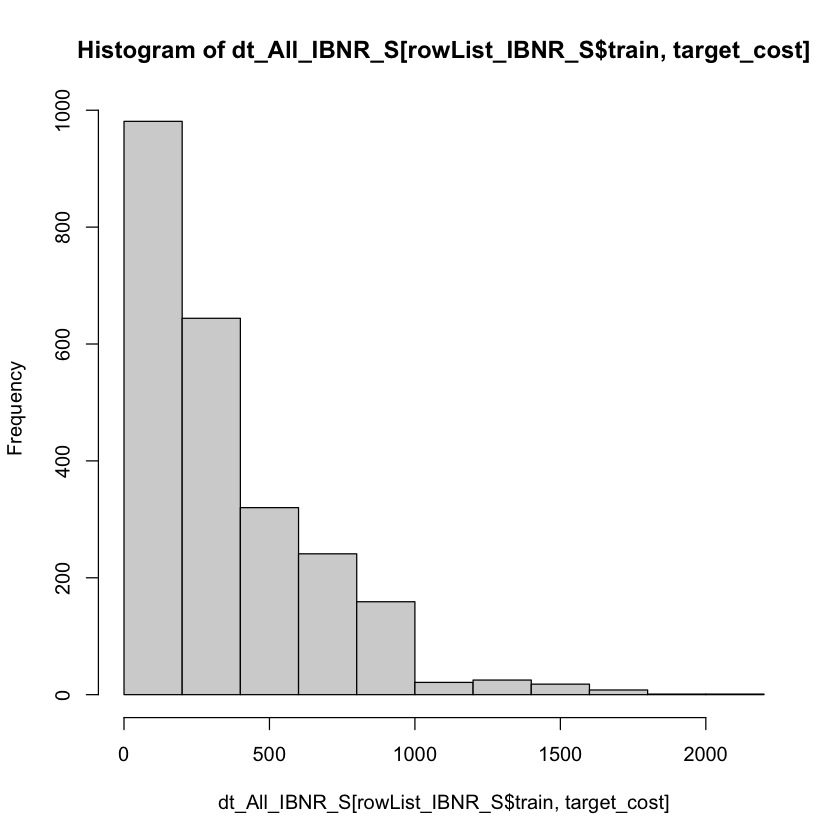

In [37]:
summary(dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])
hist(dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])

In [38]:
param <- list(
  objective = "reg:gamma",
  max_depth = 2L,           # tree-depth
  subsample = 0.7,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,   # randomly sample columns before fitting each tree
  min.child.weight = 10,    # minimum weight per leaf
  eta = 0.1               # Learning rate
  #monotone_constraints = monotone_Vec # Monotonicity constraints
)

# Train model with cross validation
set.seed(1984) # for repeatability

xgb_IBNR_S_CV <- xgb.cv(
 params                 = param,
 data                   = xgb.IBNR_S_DMat.train,
 nrounds                = 2000,        # Maximum number of trees to build
 nfold = 5,

 early_stopping_rounds  = 50L,        # Stops algorithm early if performance has not improved in n rounds
 print_every_n          = 50L,        # How often to print to console
 #base_score             = 0.001,       # Model starting point
   prediction             = TRUE        # Keeps the predictions
) 

[1]	train-gamma-nloglik:727.366760+11.680331	test-gamma-nloglik:726.538232+48.084103 
Multiple eval metrics are present. Will use test_gamma_nloglik for early stopping.
Will train until test_gamma_nloglik hasn't improved in 50 rounds.

[51]	train-gamma-nloglik:6.846936+0.079307	test-gamma-nloglik:6.850900+0.394632 
[101]	train-gamma-nloglik:2.031303+0.001389	test-gamma-nloglik:2.039524+0.065692 
[151]	train-gamma-nloglik:2.001972+0.001599	test-gamma-nloglik:2.018300+0.062185 
Stopping. Best iteration:
[133]	train-gamma-nloglik:2.002924+0.001819	test-gamma-nloglik:2.016062+0.064368



Having fitted an initial model the out-of-fold predictions are stored.

In [39]:
dt_All_IBNR_S[rowList_IBNR_S$train, preds_oof_IBNR_S := xgb_IBNR_S_CV$pred]
dt_All_IBNR_S[rowList_IBNR_S$train, preds_oof_IBNR_Cost := exposure * preds_oof_IBNR_S]


### Fit final model on all training data

Having fit the model using 5 fold cross validation we observe the optimum number of fitting rounds to be `r xgb_IBNR_S_CV$best_iteration`. 

We can then us this to train a final model on all the data. 

In [40]:


xgb_IBNR_S_Fit <- xgb.train(
   params                 = param,
   data                   = xgb.IBNR_S_DMat.train,
   nrounds                = xgb_IBNR_S_CV$best_iteration,
# base_score             = 1,
   watchlist              = list(train=xgb.IBNR_F_DMat.train, test=xgb.IBNR_F_DMat.test) ,
   print_every_n          = 50
 )


[1]	train-gamma-nloglik:1.072412	test-gamma-nloglik:1.046510 
[51]	train-gamma-nloglik:1.000593	test-gamma-nloglik:1.000379 
[101]	train-gamma-nloglik:1.000120	test-gamma-nloglik:1.000075 
[133]	train-gamma-nloglik:1.000126	test-gamma-nloglik:1.000079 


Having trained the model the predictions are stored. 

In [41]:
dt_All_IBNR_S[rowList_IBNR_S$all, preds_full_IBNR_Cost := predict(xgb_IBNR_S_Fit,xgb.IBNR_S_DMat.all)]

### Inspect model fit

Having fitted the full model we can then inspect the model fit. The traditional way of inspecting global model feature importance is to use the gains chart. 

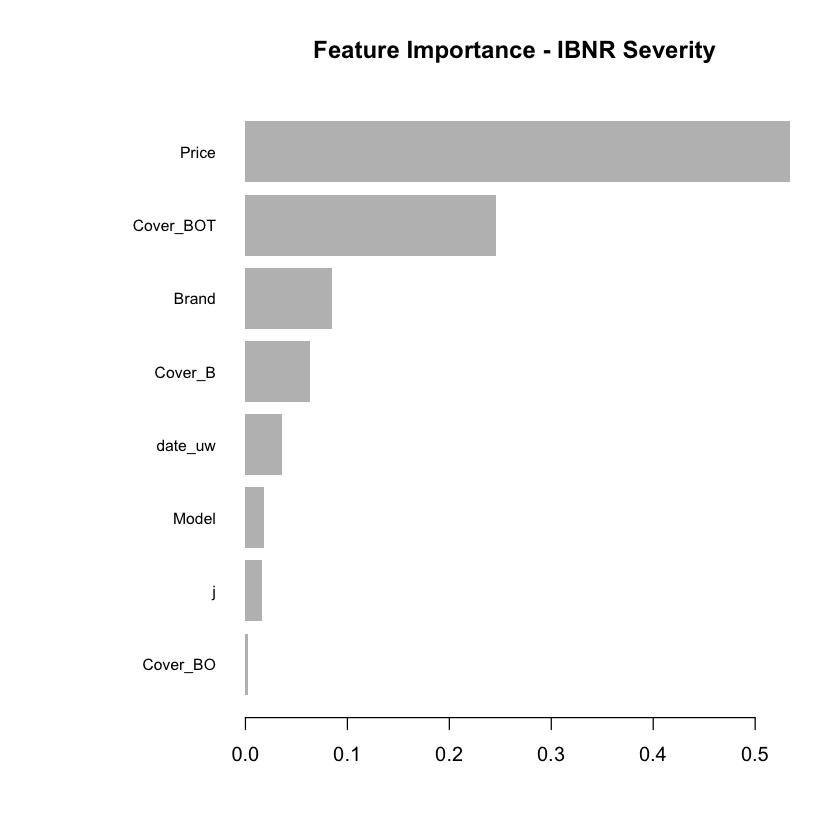

In [42]:

#default feature importance by gain
featImp_IBNR_S <- xgb.importance(xgb_IBNR_S_Fit, feature_names = colnames(xgb.IBNR_S_DMat.train))
xgb.plot.importance(featImp_IBNR_S, main="Feature Importance - IBNR Severity")


An increasingly popular and more robust approach is to use SHAP values [https://github.com/slundberg/shap](http://).  The SHAP equivalent of the feature importance chart is shown below.

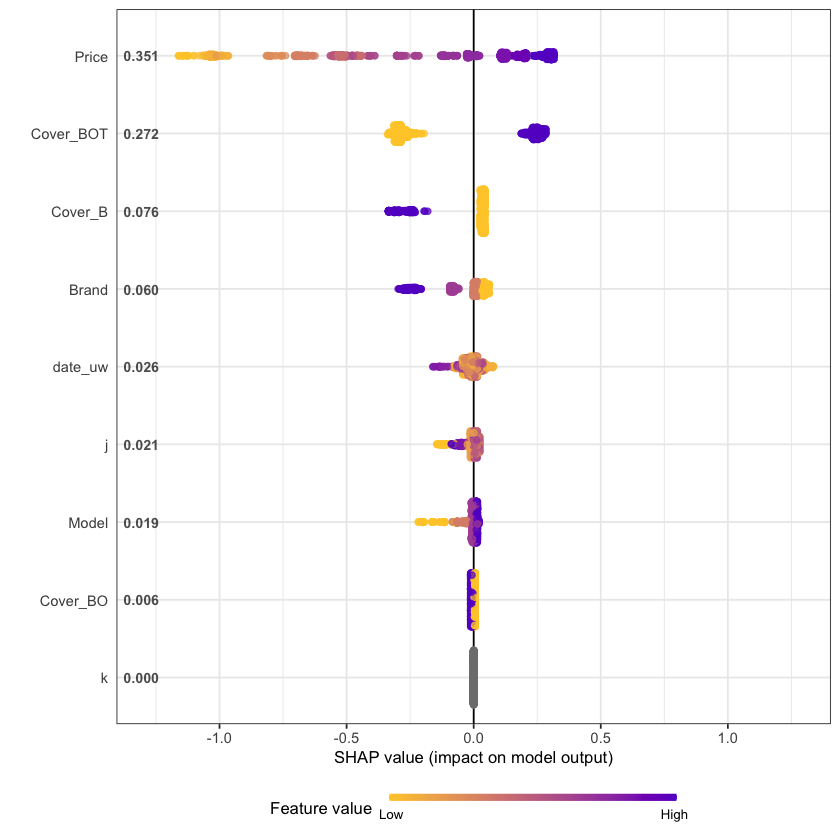

In [43]:
# Return the SHAP values and ranked features by mean|SHAP|
shap_values <- shap.values(xgb_model = xgb_IBNR_S_Fit, X_train = as.matrix(df.IBNR_S_train))

# Prepare the long-format data:
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train =  as.matrix(df.IBNR_S_train))

# **SHAP summary plot**
shap.plot.summary(shap_long, dilute = max(nrow(df.IBNR_S_train),10000)/10000)

A second useful chart is the partial dependence plot. This shows how the values of a predictive (input) feature influence the predicted (output) value, while holding the values of all other predictive (input) features constant. It is also known as the marginal effect.

Here we show the partial dependence plots for the top 4 SHAP features.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”
`geom_smooth()` using formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  2.5e-05”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“all data on boundary of neighborhood. make span bigger”
Warning message in sim

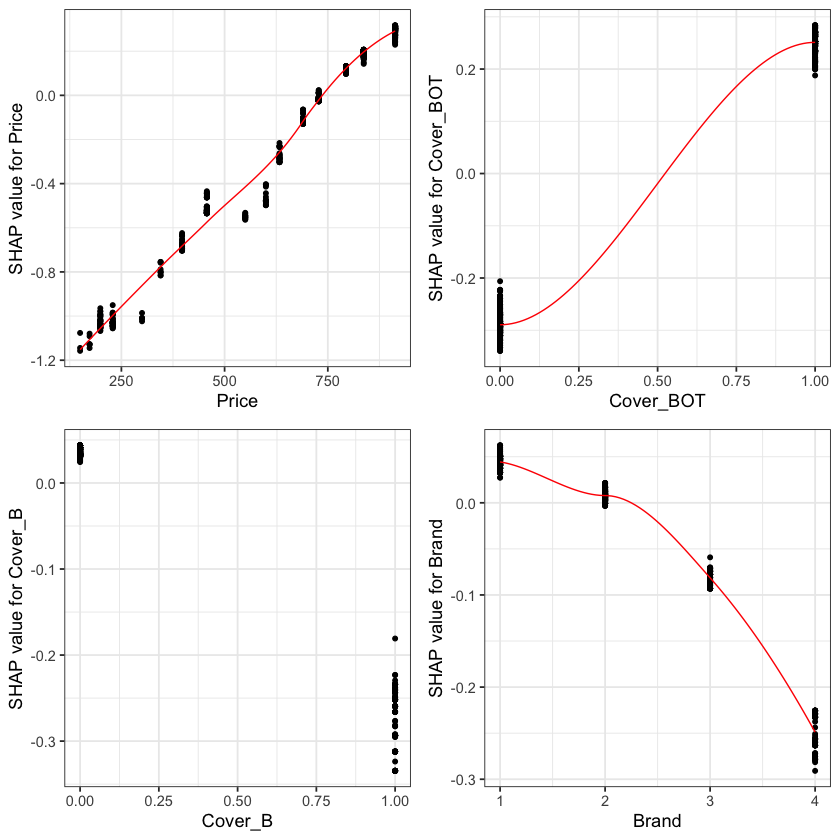

In [44]:
fig_list <- lapply(names(shap_values$mean_shap_score)[1:4], 
                   shap.plot.dependence,
                   data_long = shap_long,
                   dilute = nrow(shap_long)/ 10000)

gridExtra::grid.arrange(grobs = fig_list, ncol = 2)

The feature importance and partial dependency plots provide quick insight into the model.  

* We see that phone price is the most important feature and has a linear relationship with IBNR severity as we would expect from the data generating process.
* The second and third most important features relate to phone cover. We see that cover BOT is associated with higher IBNR costs whereas cover B is associated with lower.  
* The fourth feature is phone brand and follows the pattern we would expect from the data simulation process.

SHAP values can also be used to show the components of a single prediction. In the following plot we show the top 4 components for each row of the data and zoom in at row 500. 

The SHAP values of the Rest 5 features were summed into variable 'rest_variables'.


Data has N = 1111 | zoom in length is 111 at location 500.




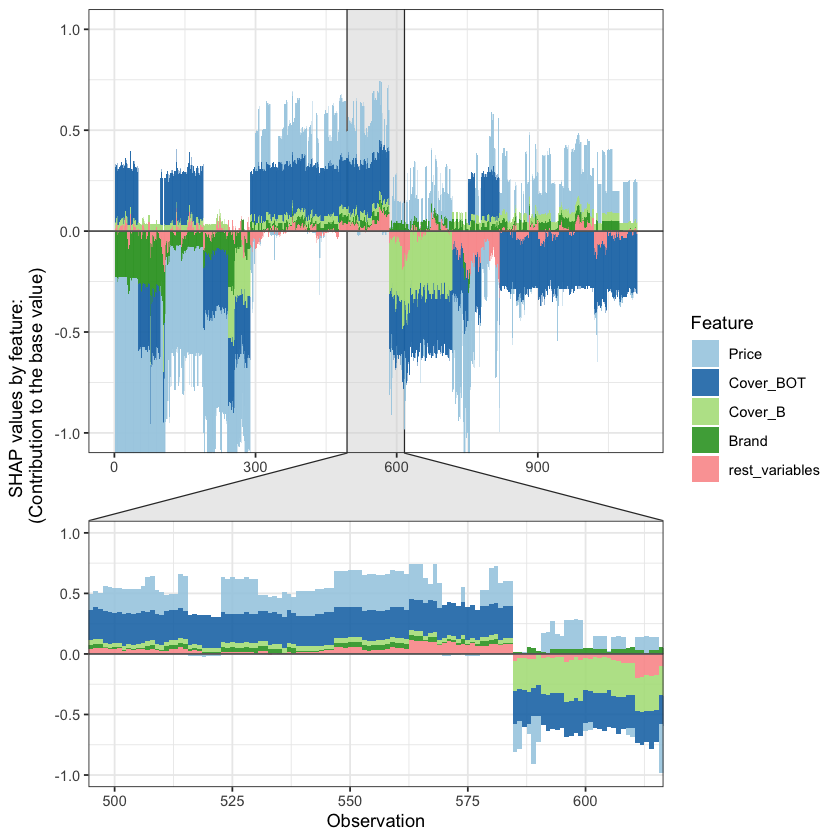

In [45]:
# choose to show top 4 features by setting `top_n = 4`, set 6 clustering groups.  
plot_data <- shap.prep.stack.data(shap_contrib = shap_values$shap_score,
                                  data_percent = 10000/max(nrow(shap_long),10000),
                                  top_n = 4,
                                  n_groups = 6)
  
# choose to zoom in at location 500, set y-axis limit using `y_parent_limit`  
# it is also possible to set y-axis limit for zoom-in part alone using `y_zoomin_limit`  
shap.plot.force_plot(plot_data, zoom_in_location = 500, y_parent_limit = c(-1,1))
  

### Summarising IBNR claim costs

By comparing the model predictions to the simulated claims run-off we can get a feel for the accuracy of the machine learning approach. Below I aggregate the IBNR claim cost predictions by claim occurrence month and compare them to the known simulated claim run-off.

In [46]:
dt_All_IBNR_S_summary <- dt_All_IBNR_S[rowList_IBNR_S$test,.(preds = sum(preds_full_IBNR_Cost), target = sum(target_cost)), keyby = date_pol_start_YYYYMM]

In [47]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_pol_start_YYYYMM = "Total"), dt_All_IBNR_S_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_All_IBNR_S_summary <- rbind(dt_All_IBNR_S_summary, sumrow, fill = TRUE)

dt_All_IBNR_S_summary[, ':='(Diff = (preds - target),
                     Diff_pcnt = scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_All_IBNR_S_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_pol_start_YYYYMM,preds,target,Diff,Diff_pcnt
2016.01,"57,417","52,782","4,635",8.8%
2016.02,"55,351","55,615",-264,-0.5%
2016.03,"52,700","47,200","5,500",11.7%
2016.04,"55,108","56,975","-1,867",-3.3%
2016.05,"64,834","64,833",1,0.0%
2016.06,"53,147","52,989",158,0.3%
2016.07,"51,445","50,276","1,169",2.3%
2016.08,"51,825","53,502","-1,677",-3.1%
2016.09,"18,725","18,989",-264,-1.4%
Total,"460,551","453,161","7,390",1.6%


# Summary

In this third notebook we have stepped through the process to apply machine learning techniques in order to create reserve estimates following the techniques set out in sections 3 and 4 of Baudry's paper.

Specifically we have shown how to apply the xgboost machine learning algorithm and illustrated how it can, with little human input, create reasonable reserve estimates as shown below. 

In [48]:

summary_table <- data.table(
  Reserve = c("RBNS", "IBNR", "TOTAL"),
  Prediction = c(dt_All_RBNS[rowList_RBNS$test, sum(preds_full)],
                 dt_All_IBNR_S[rowList_IBNR_S$test, sum(preds_full_IBNR_Cost)],
                 dt_All_RBNS[rowList_RBNS$test, sum(preds_full)] + dt_All_IBNR_S[rowList_IBNR_S$test, sum(preds_full_IBNR_Cost)]),
  Ground_Truth = c(dt_All_RBNS[rowList_RBNS$test, sum(target)],
                   dt_All_IBNR_S[rowList_IBNR_S$test, sum(target_cost)],
                   dt_All_RBNS[rowList_RBNS$test, sum(target)] + dt_All_IBNR_S[rowList_IBNR_S$test, sum(target_cost)])
)

summary_table[, ':='(
  Diff = (Prediction - Ground_Truth),
  Diff_pcnt =  scales::percent((Prediction - Ground_Truth) / Ground_Truth, accuracy = 0.1)
)]


kable(
  summary_table,
  "html",
  digits = c(0, 0, 0, 0, 1),
  format.args = list(big.mark = ",",
                     scientific = FALSE)
) %>%
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

Reserve,Prediction,Ground_Truth,Diff,Diff_pcnt
RBNS,"1,021,285","1,022,981","-1,696",-0.2%
IBNR,"460,551","453,161","7,390",1.6%
TOTAL,"1,481,836","1,476,142","5,694",0.4%


In addition we have seen how we can create explanations for the reserve predictions using feature importance and partial dependence plots. We have also used SHAP values which can be used to explain both global features and individual predictions. 
 
In so doing, it is hoped that this series of notebooks encourage further exploration of Baudry's paper and the wider field of machine learning in reserving. The code supporting this notebook along with the supporting files and folders available in a zip file [here](/mlr-blog/l_baudry/Baudry_3.zip).

Download and extract the zip file to a local directory and then open the R project file Baudry_3.rproj in your local R software installation. In the root of the project folder you will see two files;

* Notebook_3_ApplyMachineLearningReserving_v1.Rmd - which is the source code used to recreate this notebook  
* Notebook_3_ApplyMachineLearningReserving_v1.R - the equivalent code provided as an R script

Please note that, depending upon your R installation , you may have to install R libraries before you can run the code provided. R will warn you if you have missing dependencies and you can then install them from CRAN.


